In [1]:
import numpy as np
from mpl_toolkits import mplot3d
from rom_am import *
import matplotlib.pyplot as plt
import pandas as pd
import scipy.interpolate as si

## Creating the snapshots

In [2]:
with open("../DATA/Piezo/with_accel/press_data.csv") as f:
    lines = (line for line in f if not line.startswith('#'))
    pres = np.loadtxt(lines, delimiter=',',) ## -------------- Pressure
with open("../DATA/Piezo/with_accel/meshx_data.csv") as f:
    lines = (line for line in f if not line.startswith('#'))
    meshx = np.loadtxt(lines, delimiter=',',) ## -------------- Mesh x_displ
with open("../DATA/Piezo/with_accel/meshy_data.csv") as f:
    lines = (line for line in f if not line.startswith('#'))
    meshy = np.loadtxt(lines, delimiter=',',) ## -------------- Mesh y_displ
with open("../DATA/Piezo/with_accel/vx_data.csv") as f:
    lines = (line for line in f if not line.startswith('#'))
    vx = np.loadtxt(lines, delimiter=',',) ## -------------- x-velocity
with open("../DATA/Piezo/with_accel/vy_data.csv") as f:
    lines = (line for line in f if not line.startswith('#'))
    vy = np.loadtxt(lines, delimiter=',',) ## -------------- y-velocity
with open("../DATA/Piezo/with_accel/solid_accel_x.csv") as f:
    lines = (line for line in f if not line.startswith('#'))
    uddot_x = np.loadtxt(lines, delimiter=',',) ## -------------- solid x-acceleration
with open("../DATA/Piezo/with_accel/solid_accel_y.csv") as f:
    lines = (line for line in f if not line.startswith('#'))
    uddot_y = np.loadtxt(lines, delimiter=',',) ## -------------- solid y-acceleration
with open("../DATA/Piezo/with_accel/solid_disp_x.csv") as f:
    lines = (line for line in f if not line.startswith('#'))
    u_x = np.loadtxt(lines, delimiter=',',)    ## -------------- solid x-displacement
with open("../DATA/Piezo/with_accel/solid_disp_y.csv") as f:
    lines = (line for line in f if not line.startswith('#'))
    u_y = np.loadtxt(lines, delimiter=',',) ## -------------- solid y-displacement
with open("../DATA/Piezo/with_accel/solid_veloc_x.csv") as f:
    lines = (line for line in f if not line.startswith('#'))
    u_dt_x = np.loadtxt(lines, delimiter=',',) ## -------------- solid y-displacement
with open("../DATA/Piezo/with_accel/solid_veloc_y.csv") as f:
    lines = (line for line in f if not line.startswith('#'))
    u_dt_y = np.loadtxt(lines, delimiter=',',) ## -------------- solid y-displacement
    
    
# =============== FLuid mesh data =============================================

## ------- Nodes --------------
coor = pd.read_csv('../DATA/Piezo/coordinates.csv', sep=' |,|[|]', 
                  engine='python', header=None, skiprows=1).to_numpy()[:, :4]
coor = coor[np.argsort(coor[:, 0]), :]

## ------- Elements --------------
elems_tr = pd.read_csv('../DATA/Piezo/with_accel/fl_elem_connec.csv', sep=' |,|[|]', 
                  engine='python', header=None, nrows=42664, skiprows=1, ).to_numpy()[:, :4]
elems_tr = elems_tr[np.argsort(elems_tr[:, 0]), :]
elems_tr[:, 1::] = elems_tr[:, 1::] - 1

elems_tet = pd.read_csv('../DATA/Piezo/with_accel/fl_elem_connec.csv', sep=' |,|[|,|]', 
                  engine='python', header=None, skiprows=42666, ).to_numpy()[:, :5]
elems_tet = elems_tet[np.argsort(elems_tet[:, 0]), :]
elems_tet[:, 1::] = elems_tet[:, 1::] - 1



# =============== Solid mesh data =============================================

## ------- Nodes --------------
s_coor = pd.read_csv('../DATA/Piezo/with_accel/solid_coord.csv', sep=' |,|[|]', 
                  engine='python', header=None, skiprows=1).to_numpy()[:, :4]
s_coor = s_coor[np.argsort(s_coor[:, 0]), :]
s_coor[:, 0] = s_coor[:, 0].astype(int)

## ------- Elements --------------
s_elems = pd.read_csv('../DATA/Piezo/with_accel/solid_elem_connec.csv', sep=' |,|[|,|]', 
                  engine='python', header=None, skiprows=1, ).to_numpy()[:, :5]
s_elems = s_elems[np.argsort(s_elems[:, 0]), :]
#s_elems[:, 1::] = s_elems[:, 1::] - 1 - (s_coor[:, 0].min() - 1)
s_elems = s_elems.astype(int)



## Time and geometric shape
ntt = pres.shape[1]
nxx = pres.shape[0]
dt = 2e-2
data_t = np.arange(0, ntt)*dt
t1 = 0

# Time domain for solid is different
s_nxx = s_coor.shape[0]
s_ntt = u_x.shape[1]
s_dt = 3e-2
s_data_t = np.arange(0, s_ntt)*s_dt
u_x = si.griddata(s_data_t, u_x.T, data_t, method='linear').T
u_y = si.griddata(s_data_t, u_y.T, data_t, method='linear').T
uddot_x = si.griddata(s_data_t, uddot_x.T, data_t, method='linear').T
uddot_y = si.griddata(s_data_t, uddot_y.T, data_t, method='linear').T
u_dt_x = si.griddata(s_data_t, u_dt_x.T, data_t, method='linear').T
u_dt_y = si.griddata(s_data_t, u_dt_y.T, data_t, method='linear').T

## Coordinates of the reference mesh
x = coor[:, 1]
y = coor[:, 2]

## Indices of nodes at the positive normal Z face
z_pos_id = np.isclose(coor[:, -1], 0.025)
z_pos_coor = coor[z_pos_id, :]
x_z_pos = z_pos_coor[:, 1]
y_z_pos = z_pos_coor[:, 2]

In [3]:
## ===================== Fixing solid mesh data =====================
lookin = s_coor[:, 0].astype(int)

for i in range(s_elems.shape[0]):
    for j in range(s_elems.shape[1] - 1):
        s_elems[i, j+1] = np.where(lookin == s_elems[i, j+1])[0][0]

In [4]:
data = np.vstack((pres, vx, vy, meshx, meshy, u_x, u_y, uddot_x, uddot_y)) # Input data

## Taking a fraction of data for training
Coeff = .8
X = data[:, :-1][:, :int(ntt*Coeff)]
Y = data[:, 1::][:, :int(ntt*Coeff)]
training_t = data_t[:int(ntt*Coeff)]

## The rest for testing
X_test = data[:, :-1][:, int(ntt*Coeff)::]
Y_test = data[:, 1::][:, int(ntt*Coeff)::]

## DMD Reduction

In [5]:
dmd = DMD()
drom = ROM(dmd)
drom.decompose(X,  Y = Y, dt = dt, sorting = "abs", normalize=True, opt_trunc=True)

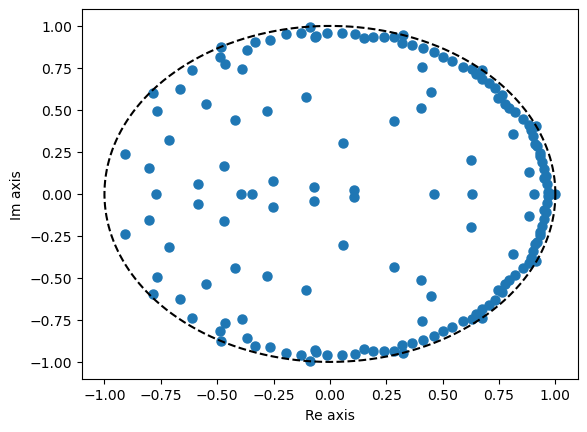

In [6]:
plt.plot(np.real(drom.model.lambd), np.imag(drom.model.lambd), '.', markersize = 13);
plt.xlabel("Re axis");
plt.ylabel("Im axis");
theta = np.linspace(0, 2*np.pi, 1024)
plt.plot(np.cos(theta), np.sin(theta), "k--");

## DMD Prediction

In [7]:
pred_t = np.concatenate((data_t, data_t[:int(.6 * ntt)] + data_t[-1]))
prediction = np.real(drom.predict(pred_t, method=0, t1=t1,))

## Extract predicted fields
pred_pres = prediction[:nxx, :]
pred_vx = prediction[nxx:2*nxx, :]
pred_vy = prediction[2*nxx:3*nxx, :]
pred_meshx = prediction[3*nxx:4*nxx, :]
pred_meshy = prediction[4*nxx:5*nxx, :]
pred_u_x = prediction[5*nxx:5*nxx+s_nxx, :]
pred_u_y = prediction[5*nxx+s_nxx:5*nxx+2*s_nxx, :]
pred_uddot_x = prediction[5*nxx+2*s_nxx:5*nxx+3*s_nxx, :]
pred_uddot_y = prediction[5*nxx+3*s_nxx::, :]

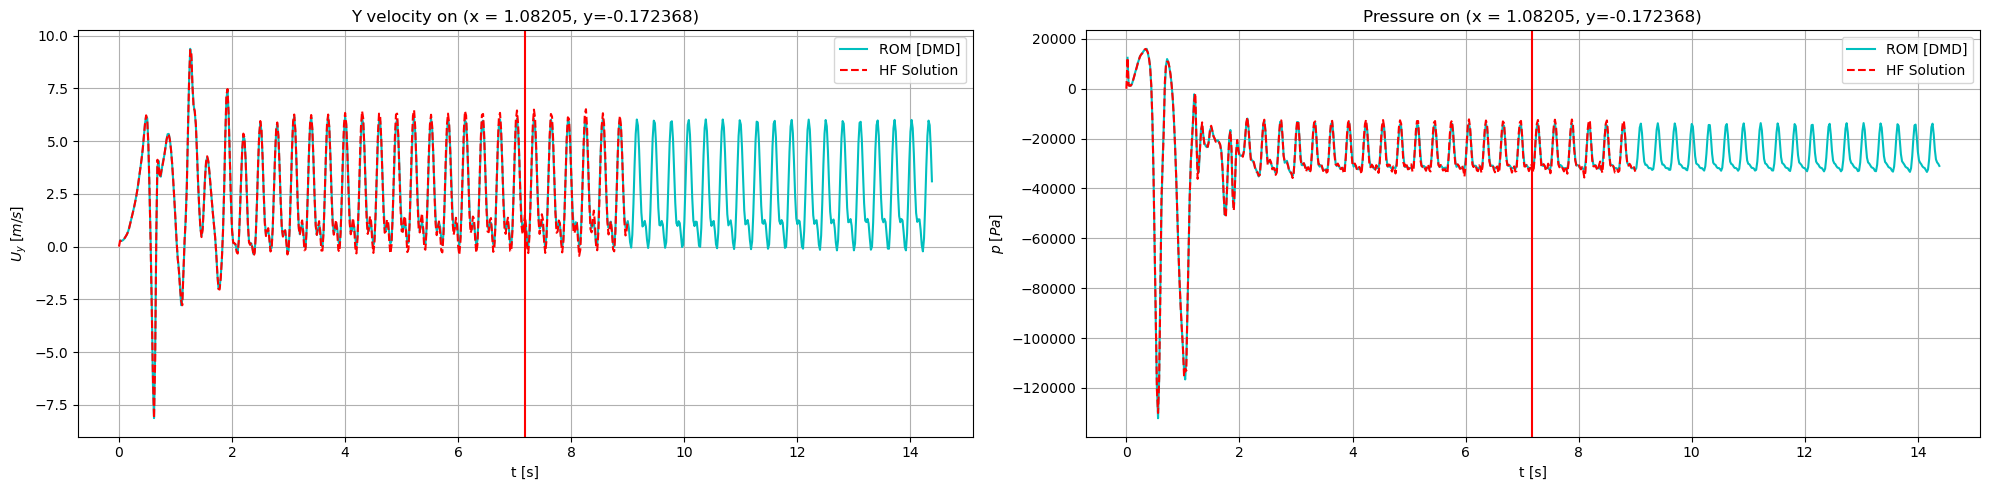

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

id_ = 2918

ax[0].plot(pred_t[1::], pred_vy[id_, :][1::], 'c', label = "ROM [DMD]");
ax[0].plot(data_t, vy[id_, :], '--r', label = "HF Solution");
ax[0].axvline(training_t[-1], color = 'r');
ax[0].grid();
ax[0].set_xlabel("t [s]");
ax[0].set_ylabel(r"$U_y \;[m/s]$");
ax[0].legend();
ax[0].set_title("Y velocity on (x = "+str(x[id_])+", y="+str(y[id_])+")");

ax[1].plot(pred_t[1::], pred_pres[id_, :][1::], 'c', label = "ROM [DMD]");
ax[1].plot(data_t, pres[id_, :], '--r', label = "HF Solution");
ax[1].axvline(training_t[-1], color = 'r');
ax[1].grid();
ax[1].set_xlabel("t [s]");
ax[1].set_ylabel(r"$p \;[Pa]$");
ax[1].legend();
ax[1].set_title("Pressure on (x = "+str(x[id_])+", y="+str(y[id_])+")");
plt.tight_layout();

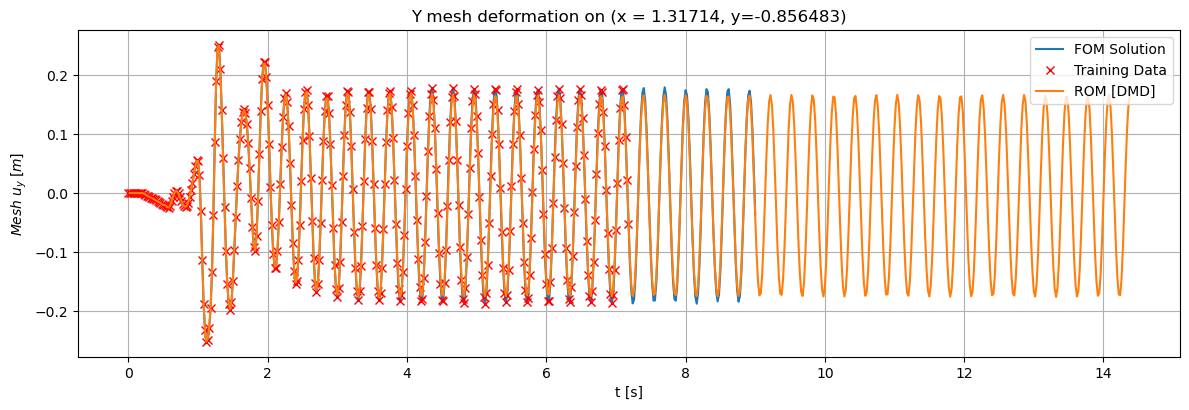

In [9]:
id_ = 5000

figure = plt.figure(figsize = (12, 4))
plt.plot(data_t, meshy[id_, :], label = "FOM Solution");
plt.plot(training_t, meshy[id_, :int(ntt * Coeff)], 'xr', label = "Training Data");
plt.plot(pred_t[1::], pred_meshy[id_, :][1::], label = "ROM [DMD]");
plt.grid();
plt.xlabel("t [s]");
plt.ylabel(r"$Mesh \; u_y \;[m]$");
plt.legend();
plt.tight_layout();
plt.title("Y mesh deformation on (x = "+str(x[id_])+", y="+str(y[id_])+")");

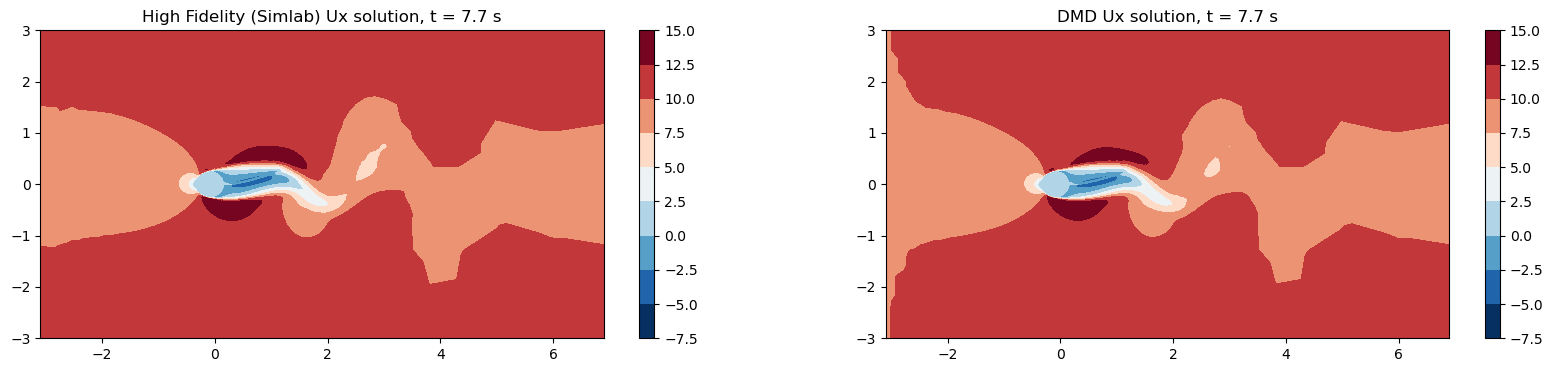

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(20, 4))
instant = int(ntt*Coeff) + 25

vmin = min(vx[z_pos_id, instant].min(), pred_vx[z_pos_id, instant].min())
vmax = max(vx[z_pos_id, instant].max(), pred_vx[z_pos_id, instant].max())

curr_x = x_z_pos+meshx[z_pos_id, instant]
curr_y = y_z_pos+meshy[z_pos_id, instant]
c0 = ax[0].tricontourf(curr_x, curr_y, vx[z_pos_id, instant], cmap='RdBu_r', vmin=vmin, vmax=vmax);
plt.colorbar(c0, ax=ax[0]);
ax[0].set_title("High Fidelity (Simlab) Ux solution, t = "+str(data_t[instant])+" s");

curr_x = x_z_pos+pred_meshx[z_pos_id, instant]
curr_y = y_z_pos+pred_meshy[z_pos_id, instant]
c1 = ax[1].tricontourf(curr_x, curr_y, pred_vx[z_pos_id, instant], vmin=vmin, vmax=vmax, cmap='RdBu_r',);
plt.colorbar(c0, ax=ax[1]);
ax[1].set_title("DMD Ux solution, t = "+str(data_t[instant])+" s");

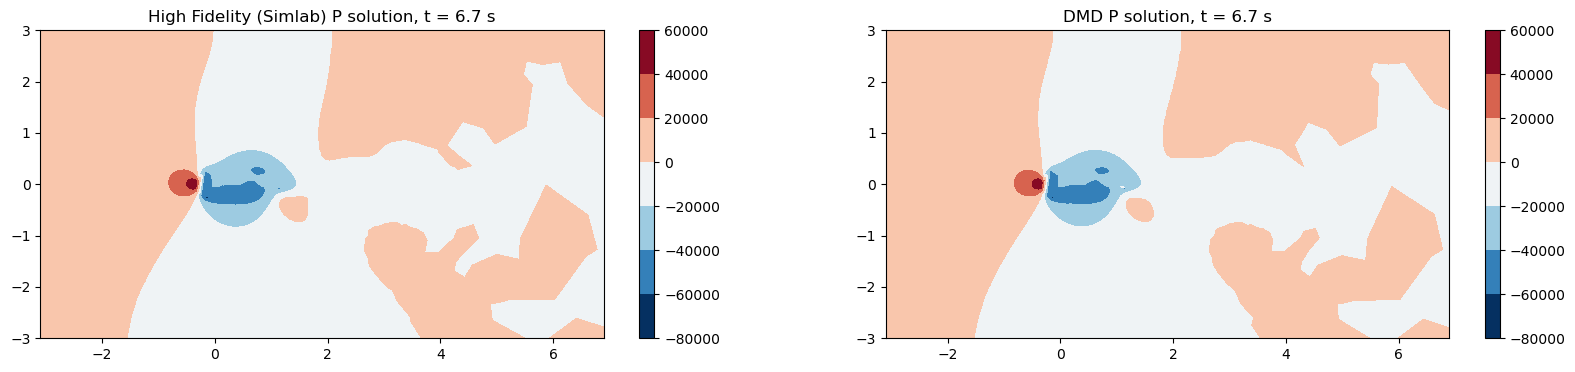

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(20, 4))
instant = int(ntt*Coeff) -25

vmin = min(pres[z_pos_id, instant].min(), pred_pres[z_pos_id, instant].min())
vmax = max(pres[z_pos_id, instant].max(), pred_pres[z_pos_id, instant].max())

curr_x = x_z_pos+meshx[z_pos_id, instant]
curr_y = y_z_pos+meshy[z_pos_id, instant]
c0 = ax[0].tricontourf(curr_x, curr_y, pres[z_pos_id, instant], cmap='RdBu_r', vmin=vmin, vmax=vmax);
plt.colorbar(c0, ax=ax[0]);
ax[0].set_title("High Fidelity (Simlab) P solution, t = "+str(data_t[instant])+" s");

curr_x = x_z_pos+pred_meshx[z_pos_id, instant]
curr_y = y_z_pos+pred_meshy[z_pos_id, instant]
c1 = ax[1].tricontourf(curr_x, curr_y, pred_pres[z_pos_id, instant], vmin=vmin, vmax=vmax, cmap='RdBu_r',);
plt.colorbar(c0, ax=ax[1]);
ax[1].set_title("DMD P solution, t = "+str(data_t[instant])+" s");

In [12]:
print("Training time : ", drom.profile["Training time"], " s")

Training time :  4.899943828582764  s


In [13]:
print("Prediction time : ", drom.profile["Prediction time"], " s")

Prediction time :  2.0064120292663574  s


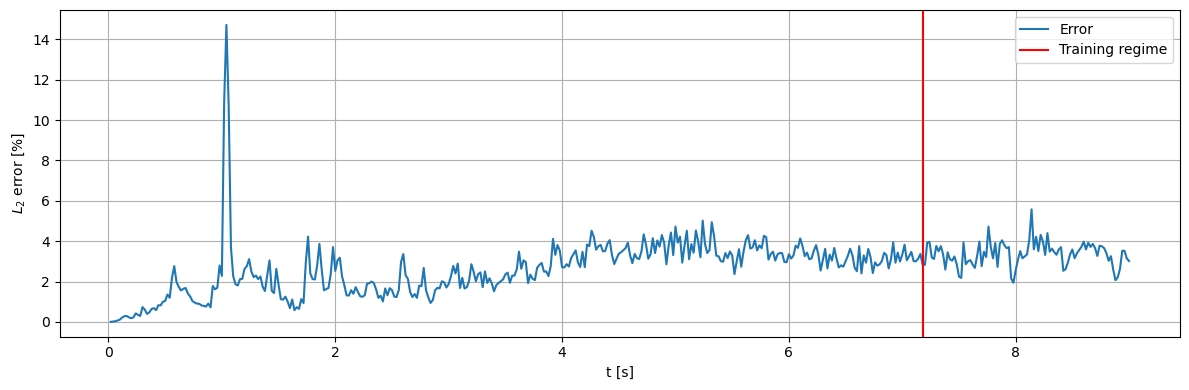

In [14]:
figure = plt.figure(figsize = (12, 4))

reference = data.copy()
er_pred_t = data_t.copy()
er_pred = np.real(drom.predict(er_pred_t, method=0, t1=t1,))
errors = np.linalg.norm(er_pred-reference, axis =0)/np.linalg.norm(reference, axis =0)

plt.plot(er_pred_t[1::], 100 * errors[1::], '-', label = 'Error');
plt.axvline(x = training_t[-1], color = 'red', label = 'Training regime');
plt.grid();
plt.xlabel("t [s]");
plt.ylabel("$L_2$ error [%]");
plt.legend();
plt.tight_layout();

**Exporting results and meshio meshes - FOM Solution**

In [ ]:
import meshio

# =============== Fluid mesh  ==============================
filename = "fluid_HF.vtk"
points = coor[:, 1::]
cells = [
    ("triangle", elems_tr[:, 1::]),
    ("tetra", elems_tet[:, 1::]),
]

mesh = meshio.Mesh(
    points,
    cells,
)

# export
with meshio.xdmf.TimeSeriesWriter(filename) as writer:
    writer.write_points_cells(points, cells)
    for i in range(len(data_t)):
        writer.write_data(data_t[i], point_data={"FOM_pressure": pres[:, i],
                                                "FOM_mesh_disp": np.hstack((meshx[:, i].reshape((-1,1)), meshy[:, i].reshape((-1,1)), np.zeros(meshx.shape[0]).reshape((-1,1)))),
                                                "FOM_velocity": np.hstack((vx[:, i].reshape((-1,1)), vy[:, i].reshape((-1,1)), np.zeros(meshx.shape[0]).reshape((-1,1))))})


In [ ]:
# =============== Solid mesh  ==============================
filename = "solid_HF.vtk"
s_points = s_coor[:, 1::]
s_cells = [
    ("tetra", s_elems[:, 1::]),
]

s_mesh = meshio.Mesh(
    s_points,
    s_cells,
)

# export
with meshio.xdmf.TimeSeriesWriter(filename) as writer:
    writer.write_points_cells(s_points, s_cells)
    for i in range(len(data_t)):
        writer.write_data(data_t[i], point_data={"FOM_Displacement": np.hstack((u_x[:, i].reshape((-1,1)), u_y[:, i].reshape((-1,1)), np.zeros(u_x.shape[0]).reshape((-1,1)))),
                                                 "FOM_Velocity": np.hstack((u_dt_x[:, i].reshape((-1,1)), u_dt_y[:, i].reshape((-1,1)), np.zeros(u_x.shape[0]).reshape((-1,1)))),
                                                 "FOM_Acceleration": np.hstack((uddot_x[:, i].reshape((-1,1)), uddot_y[:, i].reshape((-1,1)), np.zeros(u_x.shape[0]).reshape((-1,1))))})


**Exporting results and meshio meshes - ROM Solution**

In [16]:
# =============== Fluid mesh  ==============================
prs_error = np.empty(pred_pres.shape)
prs_error[:, :ntt] = np.sqrt(((pred_pres[:, :ntt] - pres)**2))
filename = "fluid_ROM.vtk"

# export
with meshio.xdmf.TimeSeriesWriter(filename) as writer:
    writer.write_points_cells(points, cells)
    for i in range(len(pred_t)):
        writer.write_data(pred_t[i], point_data={"DMD_pressure": pred_pres[:, i],
                                                 "Pressure_error": prs_error[:, i],
                                                "DMD_mesh_disp": np.hstack((pred_meshx[:, i].reshape((-1,1)), pred_meshy[:, i].reshape((-1,1)), np.zeros(pred_meshx.shape[0]).reshape((-1,1)))),
                                                "DMD_velocity": np.hstack((pred_vx[:, i].reshape((-1,1)), pred_vy[:, i].reshape((-1,1)), np.zeros(pred_vx.shape[0]).reshape((-1,1))))})


In [17]:
# =============== Solid mesh  ==============================
acc_error = np.empty(pred_uddot_x.shape)
acc_error[:, :ntt] = np.sqrt(((np.sqrt(pred_uddot_x[:, :ntt]**2 + pred_uddot_y[:, :ntt]**2)) - (np.sqrt(uddot_x**2 + uddot_y**2)))**2)
filename = "solid_ROM.vtk"

# export
with meshio.xdmf.TimeSeriesWriter(filename) as writer:
    writer.write_points_cells(s_points, s_cells)
    for i in range(len(pred_t)):
        writer.write_data(pred_t[i], point_data={"DMD_Displacement": np.hstack((pred_u_x[:, i].reshape((-1,1)), pred_u_y[:, i].reshape((-1,1)), np.zeros(pred_u_x.shape[0]).reshape((-1,1)))),
                                                 "acceleratio_error": acc_error[:, i],
                                                "DMD_Acceleration": np.hstack((pred_uddot_x[:, i].reshape((-1,1)), pred_uddot_y[:, i].reshape((-1,1)), np.zeros(pred_u_x.shape[0]).reshape((-1,1))))})


**Saving plots (optional)**

In [ ]:
for i in range(len(pred_t)):
    
    col = "k"
    fig, ax = plt.subplots(1, 2, figsize=(20, 4))
    instant = i
    if instant >= len(data_t):
        col = "g"

    vmin = pred_vx[z_pos_id, instant].min()
    vmax = pred_vx[z_pos_id, instant].max()
    
    if instant < len(data_t): 
        vmin = min(vx[z_pos_id, instant].min(), pred_vx[z_pos_id, instant].min())
        vmax = max(vx[z_pos_id, instant].max(), pred_vx[z_pos_id, instant].max())
        
        curr_x = x_z_pos+meshx[z_pos_id, instant]
        curr_y = y_z_pos+meshy[z_pos_id, instant]
        c0 = ax[0].tricontourf(curr_x, curr_y, vx[z_pos_id, instant], cmap='RdBu_r', vmin=vmin, vmax=vmax);
        plt.colorbar(c0, ax=ax[0]);
        ax[0].set_title("High Fidelity (Simlab) Ux solution, t = "+str(data_t[instant])+" s");
        
        if instant == len(data_t)-1:
            vmin_store = vmin
            vmax_store = vmax
            curr_x_store = curr_x.copy()
            curr_y_store = curr_y.copy()
            store_z = vx[z_pos_id, instant]
    else:
        c0 = ax[0].tricontourf(curr_x_store, curr_y_store, store_z, cmap='RdBu_r', vmin=vmin_store, vmax=vmax_store);
        plt.colorbar(c0, ax=ax[0]);
        ax[0].set_title("High Fidelity (Simlab) Ux solution, t = "+str(data_t[-1])+" s");

    curr_x = x_z_pos+pred_meshx[z_pos_id, instant]
    curr_y = y_z_pos+pred_meshy[z_pos_id, instant]
    c1 = ax[1].tricontourf(curr_x, curr_y, pred_vx[z_pos_id, instant], vmin=vmin, vmax=vmax, cmap='RdBu_r');
    plt.colorbar(c0, ax=ax[1]);
    ax[1].set_title("DMD U solution, t = "+str(pred_t[instant])+" s", {"color" : col});

    fig.savefig("../References/Piezo/u_dmd_"+str(i)+".png", bbox_inches = 'tight');

**Separating two ROMs**

- ROM1 : Transient system

In [15]:
index_stop = (data_t > 2.5).nonzero()[0][0]

In [16]:
## Taking a fraction of data for training
Coeff = .7
X2 = data[:, :-1][:, index_stop:int(ntt*Coeff)]
Y2 = data[:, 1::][:, index_stop:int(ntt*Coeff)]
training_t2 = data_t[index_stop:int(ntt*Coeff)]
t2 = training_t2[0]

## The rest for testing
X_test2 = data[:, :-1][:, int(ntt*Coeff)::]
Y_test2 = data[:, 1::][:, int(ntt*Coeff)::]

In [17]:
dmd2 = DMD()
drom2 = ROM(dmd2)
drom2.decompose(X2,  Y = Y2, dt = dt, normalize=True, opt_trunc=True)

In [18]:
pred_t2 = np.concatenate((data_t[index_stop::], data_t[index_stop::] + data_t[-1] - data_t[index_stop::][0]))
prediction2 = np.real(drom2.predict(pred_t2, method=0, t1=t2,))

## Extract predicted fields
pred_pres = prediction2[:nxx, :]
pred_vx = prediction2[nxx:2*nxx, :]
pred_vy = prediction2[2*nxx:3*nxx, :]
pred_meshx = prediction2[3*nxx:4*nxx, :]
pred_meshy = prediction2[4*nxx:5*nxx, :]

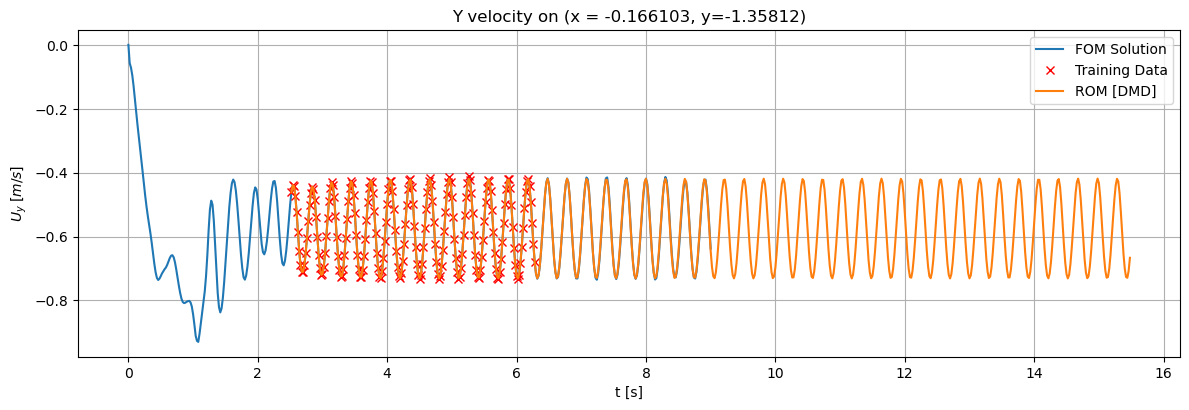

In [19]:
id_ = 1504

figure = plt.figure(figsize = (12, 4))
plt.plot(data_t, vy[id_, :], label = "FOM Solution");
plt.plot(training_t2, vy[id_, index_stop:int(ntt * Coeff)], 'xr', label = "Training Data");
plt.plot(pred_t2, pred_vy[id_, :], label = "ROM [DMD]");
plt.grid();
plt.xlabel("t [s]");
plt.ylabel(r"$U_y \;[m/s]$");
plt.legend();
plt.tight_layout();
plt.title("Y velocity on (x = "+str(x[id_])+", y="+str(y[id_])+")");

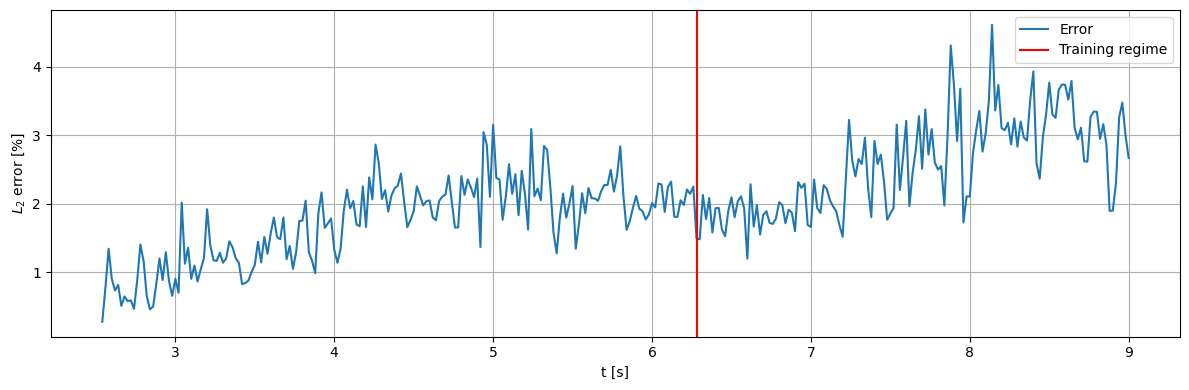

In [20]:
figure = plt.figure(figsize = (12, 4))

reference = data[:, index_stop::]
er_pred_t = data_t[index_stop::]
er_pred = np.real(drom2.predict(er_pred_t, method=0, t1=t2,))
errors = np.linalg.norm(er_pred-reference, axis =0)/np.linalg.norm(reference, axis =0)

plt.plot(er_pred_t[1::], 100 * errors[1::], '-', label = 'Error');
plt.axvline(x = training_t2[-1], color = 'red', label = 'Training regime');
plt.grid();
plt.xlabel("t [s]");
plt.ylabel("$L_2$ error [%]");
plt.legend();
plt.tight_layout();

In [21]:
errors.mean()

0.020868592382262272

In [22]:
print("Training time : ", drom.profile["Training time"], " s")

Training time :  4.899943828582764  s


In [23]:
print("Prediction time : ", drom.profile["Prediction time"], " s")

Prediction time :  1.446310043334961  s
